# Predict continuous Big Five scores

## Import packages

In [7]:
import pandas as pd
from tqdm.notebook import tqdm
from time import time
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, mutual_info_regression, RFE, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
from pathlib import Path
import pickle

import datetime

## Import data

In [2]:
# read in normal dataset
df = pd.read_pickle("b5feat.pkl")
df.name = 'allfeatures_df'
df = df[df['trait', 'openness'].notna()]
df = df[df['trait', 'conscientiousness'].notna()]
df = df[df['trait', 'extraversion'].notna()]
df = df[df['trait', 'agreeableness'].notna()]
df = df[df['trait', 'neuroticism'].notna()]
df.name = 'allfeatures_df'
df.trait.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1568 entries, -Areopagan- to zyzee
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   agreeableness      1568 non-null   float32
 1   openness           1568 non-null   float32
 2   conscientiousness  1568 non-null   float32
 3   extraversion       1568 non-null   float32
 4   neuroticism        1568 non-null   float32
 5   big5_a             1568 non-null   int16  
 6   big5_o             1568 non-null   int16  
 7   big5_c             1568 non-null   int16  
 8   big5_e             1568 non-null   int16  
 9   big5_n             1568 non-null   int16  
 10  big5_a_multi       1568 non-null   int16  
 11  big5_o_multi       1568 non-null   int16  
 12  big5_c_multi       1568 non-null   int16  
 13  big5_e_multi       1568 non-null   int16  
 14  big5_n_multi       1568 non-null   int16  
dtypes: float32(5), int16(10)
memory usage: 73.5+ KB
<class 'pandas.cor

## Trait

In [3]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, trait_name):
    featuredf = df.drop(['trait'], axis=1, level=0)
    try:
        featuredf.drop(['text'], axis=1, level=0, inplace=True)
    except KeyError:
        pass
    try:
        featuredf.drop(['data'], axis=1, level=0, inplace=True)
    except KeyError:
        pass
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols]     
    y = df['trait', trait_name]
    return x,y 

### Functions for nested stratified cross validation

In [18]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores

def get_classifier(classifier):
    if classifier == 'linear':
        return LinearRegression(n_jobs=-1)
    elif classifier == 'rfc_reg':
        return RandomForestRegressor(n_jobs=-1)
    elif classifier == 'boost_reg':
        return GradientBoostingRegressor(random_state=0)
    elif classifier == 'mlp_reg':
        return MLPRegressor(random_state=1, max_iter=1000)

    
def get_featureselection(fs, classifier, n_feat):
    if fs == 'anova':
        return SelectKBest(f_regression, k=n_feat)
    if fs == 'mutual':
        return SelectKBest(mutual_info_regression, k=n_feat)
    if fs == 'sequential_forward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='forward', n_jobs=-1)
    if fs == 'sequential_backward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='backward', n_jobs=-1)


    
def create_pipeline_cv(classifier, fs, dim, n_feat):
    if dim:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('pca', PCA(n_components=100)),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    else:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    return pipeline

def get_params(classifier):
    if classifier == 'linear':
        params = {}
    elif classifier == 'rfc_reg':
        params = {'classification__n_estimators': [50, 100, 200], 
                  'classification__max_depth': [3, 5, 10],
                  'classification__max_features': ['auto', 'sqrt', 'log2']}
    elif classifier == 'boost_reg':
        params = {'classification__n_estimators': [50, 100, 200],
                  'classification__learning_rate': [10**x for x in range(-3,3)],
                  'classification__max_depth': [3, 5, 10],
                  'classification__max_features': ['auto', 'sqrt', 'log2']}
    elif classifier == 'mlp_reg':
        params = {'classification__hidden_layer_sizes': [(50,), (100,), (200,), (500,)],
                 'classification__activation': ['logistic', 'tanh', 'relu']}

    return params


def define_outputname(traits, df, option, fs, dim, n_feat, train=False):
    if train:
        if len(traits) ==1:
            outputname =  "train_"  +str(option) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        else:
            outputname =  "train_"  +str(option) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
 
    else:
        if len(traits) ==1:
            outputname = str(option) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        else:
            outputname = str(option) +"_"   +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)

    return outputname


def save_predictors(names, predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5, j):
    if j==1:
        predictors_fold1.append(list(names))
    elif j==2:
        predictors_fold2.append(list(names))
    elif j==3:
        predictors_fold3.append(list(names))
    elif j==4:
        predictors_fold4.append(list(names))
    elif j==5:
        predictors_fold5.append(list(names))
    return predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5

def save_coefficients(coefficients, coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5, j):
    if j==1:
        coef_fold1.append(list(coefficients))
    elif j==2:
        coef_fold2.append(list(coefficients))
    elif j==3:
        coef_fold3.append(list(coefficients))
    elif j==4:
        coef_fold4.append(list(coefficients))
    elif j==5:
        coef_fold5.append(list(coefficients))
    return coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5

def save_params_folds(foldparams, params_fold1, params_fold2, params_fold3, params_fold4, params_fold5, j):
    if j==1:
        params_fold1.append(foldparams)
    elif j==2:
        params_fold2.append(foldparams)
    elif j==3:
        params_fold3.append(foldparams)
    elif j==4:
        params_fold4.append(foldparams)
    elif j==5:
        params_fold5.append(foldparams)
    return params_fold1, params_fold2, params_fold3, params_fold4, params_fold5


## Regression

In [16]:
def regress(df, traits, clf_lst, fs, dim, n_feat,train=False):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        print("Current time: ", str(datetime.datetime.now()))
        tstart=time()
        for option in clf_lst:
            print("Classifier: ", option, "\n")
            outputname = define_outputname(traits, df, option, fs, dim, n_feat)
            output = {'Traits': traits}
            
            # empty lists to save data in csv
            predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = [],[],[],[],[]
            rsquared_traits, mse_traits = [],[]
            params_fold1, params_fold2, params_fold3, params_fold4, params_fold5 = [],[],[],[],[]
            if option == 'linear':
                coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5  = [],[],[],[],[]

    
            for trait_name in traits:
                print("\nTrait to predict: ", trait_name, "(", option, ")\n")
                x,y = trait(df, trait_name)
                cv_outer = KFold(n_splits=5, shuffle=True, random_state=0)
                cv_outer_lst = cv_outer.split(x)
                
                # empty lists for saving        
                rsquared_lst, mse_lst, ytrue_lst, ypred_lst = [],[],[],[]

                plt.figure(figsize=(5, 5))
                p = Path('/home/sophia/ma_py/Big5-NLP/results/regression/')
                j=1
                for train_idx, val_idx in cv_outer_lst:
                    train_data, val_data = x.iloc[train_idx], x.iloc[val_idx]
                    train_target, val_target = y.iloc[train_idx], y.iloc[val_idx]
                    
#                     print("Fold No. ", j)
#                     print("Length of train and test: ", len(train_data), len(val_data))
#                     print("Total users in this fold: ", (len(train_data) + len(val_data)))

#                     print("\nCreate pipeline with", option, "(Fold", j,"), for trait: ", trait_name, "...\n")
            
                    clf = create_pipeline_cv(option, fs, dim, n_feat)
#                     clfnew = clf.fit(train_data, train_target)
            
                    cv_inner = KFold(n_splits=5, shuffle=True, random_state=0)
                    params = get_params(option)
                    gd_search = GridSearchCV(clf, params, scoring = 'r2', n_jobs=-1, cv=cv_inner).fit(train_data, train_target)
                    best_model = gd_search.best_estimator_
                    clfnew = best_model.fit(train_data, train_target)
                    
                    foldparams = gd_search.best_params_
                    params_fold1, params_fold2, params_fold3, params_fold4, params_fold5 = save_params_folds(foldparams, params_fold1, params_fold2, params_fold3, params_fold4, params_fold5, j)
                    
                    if dim == False:
                        names = get_names(train_data, best_model)
                        predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = save_predictors(names, predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5, j)
                    
                    if train: 
                        y_pred = clfnew.predict(train_data)
                        score = clfnew.score(train_data, train_target)
                        mse = mean_squared_error(train_target, y_pred)
                        ytrue_lst.append(train_target)
                        
                    else:
                        y_pred = clfnew.predict(val_data)
                        score = clfnew.score(val_data, val_target)
                        mse = mean_squared_error(val_target, y_pred)
                        ytrue_lst.append(val_target)
                        
                    ypred_lst.append(y_pred)
                        
                    if option == 'linear':
                        coefficients = clfnew.named_steps['classification'].coef_
                        coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5 = save_coefficients(coefficients, coef_fold1, coef_fold2, coef_fold3, coef_fold4, coef_fold5, j)
                    rsquared_lst.append(score)
                    mse_lst.append(mse)


                    j+=1
                    
                    
                  # Average results
                r_avg = np.mean(rsquared_lst)
                rsquared_traits.append(round(r_avg, 4))
                mse_avg = np.mean(mse_lst)
                mse_traits.append(round(mse_avg, 4))
                print("Average score (R squared): ", r_avg, "\nAverage MSE: ", mse_avg)

                all_ytrue = np.concatenate(ytrue_lst)
                global all_ypred
                all_ypred = np.concatenate(ypred_lst)
                i=0
                for value in all_ytrue:
                    if math.isinf(value):
                        i+=1
                print("Infinite values in y true: ", i)
                j=0
                for value in all_ypred:
                    if math.isinf(value):
                        j+=1
                print("Infinite values in y pred", j)

                title = 'Regression plot for trait ' + trait_name 
                plot = sns.regplot(x=all_ytrue, y=all_ypred, ci=None, scatter_kws={"color": "blue", "alpha":0.1}, line_kws={"color": "red"})
#                 plt.xlim([1, 101])
#                 plt.ylim([1, 101])
                plt.ylabel('Predicted scores')
                plt.xlabel('True scores')
#                 plt.axes().set_aspect('equal', 'datalim')
                plt.title(title)
                plt.savefig(Path(p, outputname + "_" + trait_name + '_linearplot.png'))
                plt.show()

#                 title = 'Regression plot for trait ' + trait_name + "with only one feature"
#                 plot = sns.regplot(x=x['subtf', 'startrek'], y=all_ytrue, ci=None,  scatter_kws={"color": "blue", "alpha":0.3}, line_kws={"color": "red"})
# #                 plt.xlim([1, 101])
# #                 plt.ylim([1, 101])
#                 plt.ylabel('True scores')
#                 plt.xlabel('Feature')
# #                 plt.axes().set_aspect('equal', 'datalim')
#                 plt.title(title)
# #                 plt.savefig(Path(p, outputname + "_" + trait_name + '_linearplot.png'))
#                 plt.show()

            print("Total r squared: ", np.mean(rsquared_traits), "Total MSE: ", np.mean(mse_traits))
            output.update({'rsquared': rsquared_traits, 'MSE': mse_traits})
            if dim==False:
                output.update({'predictors_fold1': predictors_fold1, 'predictors_fold2': predictors_fold2, 'predictors_fold3': predictors_fold3, 'predictors_fold4': predictors_fold4, 'predictors_fold5': predictors_fold5})
            if option=='linear':
                output.update({'coef_fold1': coef_fold1, 'coef_fold2': coef_fold2, 'coef_fold3': coef_fold3, 'coef_fold4': coef_fold4, 'coef_fold5': coef_fold5})
            outputdf = pd.DataFrame(output)
            outputdf.to_csv(Path(p, outputname + '.csv'), index=False)
            print("Time for entire process: %0.2fs" % (time() - tstart))

            

big5_traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
regres = ['linear', 'rfc_reg', 'boost_reg', 'mlp_reg']

## Regressions on continuous traits

Current time:  2021-05-18 14:57:02.611586
Classifier:  linear 


Trait to predict:  openness ( linear )

Average score (R squared):  -0.018021544700827265 
Average MSE:  785.5019094669487
Infinite values in y true:  0
Infinite values in y pred 0


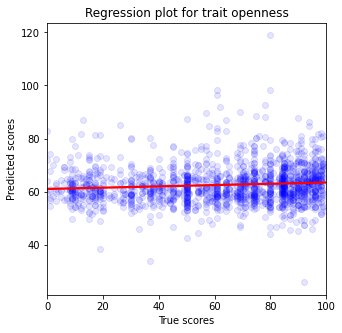


Trait to predict:  conscientiousness ( linear )

Average score (R squared):  -0.059906646752994064 
Average MSE:  971.8190045178322
Infinite values in y true:  0
Infinite values in y pred 0


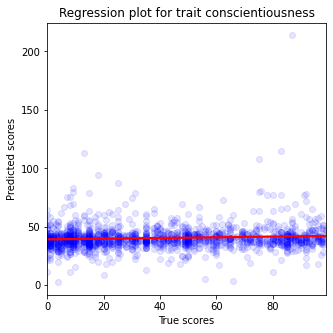


Trait to predict:  extraversion ( linear )

Average score (R squared):  -0.020819511331947194 
Average MSE:  946.4947493523283
Infinite values in y true:  0
Infinite values in y pred 0


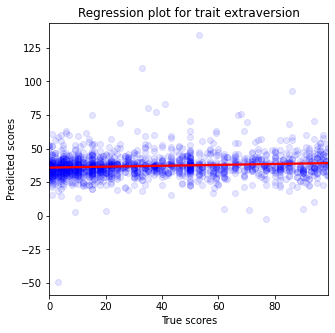


Trait to predict:  agreeableness ( linear )

Average score (R squared):  -0.0035144178435034144 
Average MSE:  959.379882573831
Infinite values in y true:  0
Infinite values in y pred 0


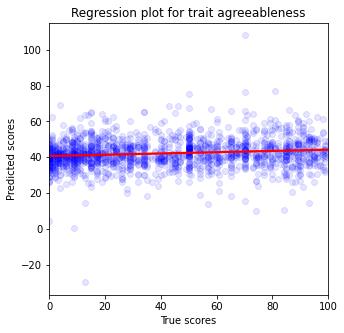


Trait to predict:  neuroticism ( linear )

Average score (R squared):  -0.0043882136084627986 
Average MSE:  1050.4832024574612
Infinite values in y true:  0
Infinite values in y pred 0


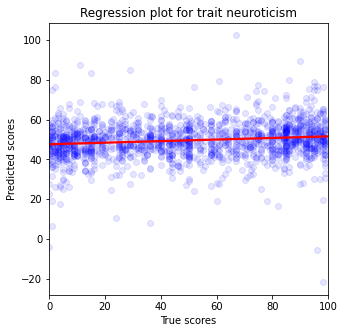

Total r squared:  -0.02132 Total MSE:  942.7357399999999
Time for entire process: 102.86s
Classifier:  rfc_reg 


Trait to predict:  openness ( rfc_reg )

Average score (R squared):  0.013568935514519187 
Average MSE:  761.2817704886431
Infinite values in y true:  0
Infinite values in y pred 0


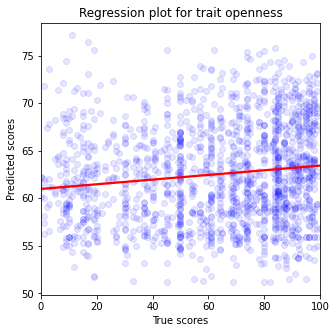


Trait to predict:  conscientiousness ( rfc_reg )

Average score (R squared):  -0.0036058132531910704 
Average MSE:  921.7301929097323
Infinite values in y true:  0
Infinite values in y pred 0


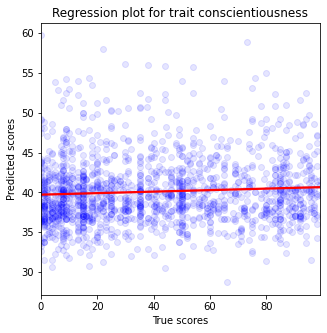


Trait to predict:  extraversion ( rfc_reg )

Average score (R squared):  0.034612224380453374 
Average MSE:  894.4106042648875
Infinite values in y true:  0
Infinite values in y pred 0


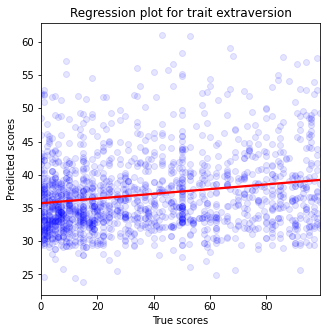


Trait to predict:  agreeableness ( rfc_reg )

Average score (R squared):  0.021965847171941166 
Average MSE:  935.1732894853101
Infinite values in y true:  0
Infinite values in y pred 0


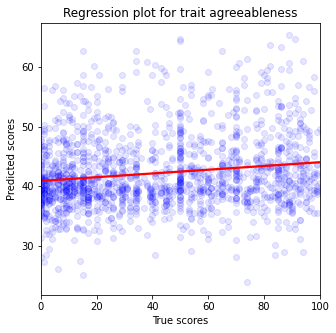


Trait to predict:  neuroticism ( rfc_reg )

Average score (R squared):  0.024194302946137135 
Average MSE:  1020.8054305911121
Infinite values in y true:  0
Infinite values in y pred 0


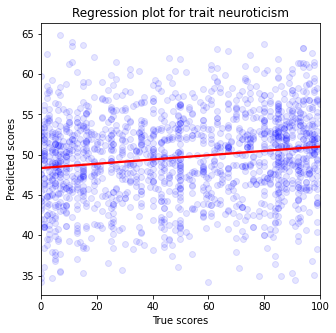

Total r squared:  0.01816 Total MSE:  906.6802599999999
Time for entire process: 896.41s
Classifier:  boost_reg 


Trait to predict:  openness ( boost_reg )

Average score (R squared):  0.01447880163748747 
Average MSE:  760.745786185316
Infinite values in y true:  0
Infinite values in y pred 0


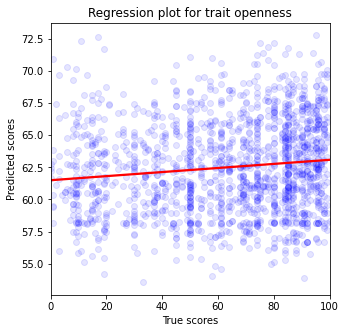


Trait to predict:  conscientiousness ( boost_reg )

Average score (R squared):  -0.000453948708264984 
Average MSE:  919.4131365321479
Infinite values in y true:  0
Infinite values in y pred 0


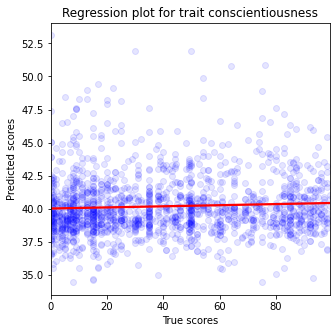


Trait to predict:  extraversion ( boost_reg )

Average score (R squared):  0.02716932964295733 
Average MSE:  901.2629709472136
Infinite values in y true:  0
Infinite values in y pred 0


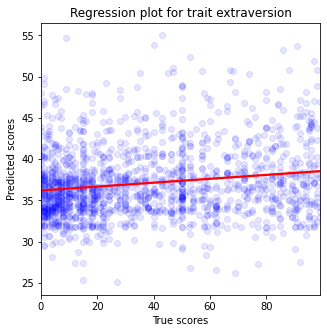


Trait to predict:  agreeableness ( boost_reg )

Average score (R squared):  0.020522124094719985 
Average MSE:  936.6290597619367
Infinite values in y true:  0
Infinite values in y pred 0


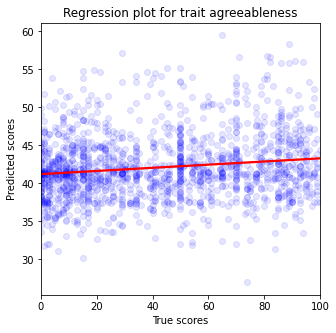


Trait to predict:  neuroticism ( boost_reg )

Average score (R squared):  0.019034502718883607 
Average MSE:  1026.2217825560942
Infinite values in y true:  0
Infinite values in y pred 0


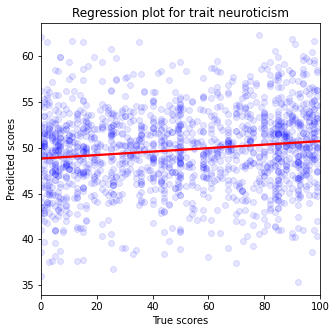

Total r squared:  0.01614 Total MSE:  908.85456
Time for entire process: 4876.20s
Classifier:  mlp_reg 


Trait to predict:  openness ( mlp_reg )



UnboundLocalError: local variable 'params' referenced before assignment

<Figure size 360x360 with 0 Axes>

In [17]:
regress(df, big5_traits, regres, 'anova', dim=False, n_feat=10)

Current time:  2021-05-18 16:22:43.760802
Classifier:  mlp_reg 


Trait to predict:  openness ( mlp_reg )

Average score (R squared):  -0.01325966811033592 
Average MSE:  781.6258657325549
Infinite values in y true:  0
Infinite values in y pred 0


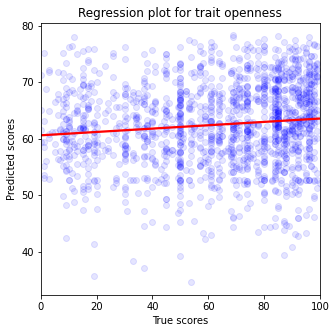


Trait to predict:  conscientiousness ( mlp_reg )

Average score (R squared):  -0.038135201749454575 
Average MSE:  951.9226389911589
Infinite values in y true:  0
Infinite values in y pred 0


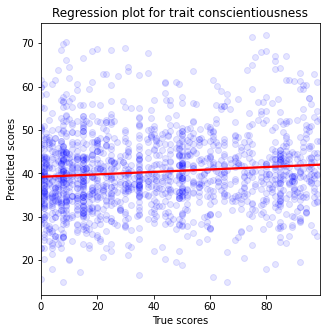


Trait to predict:  extraversion ( mlp_reg )

Average score (R squared):  0.001768363313234933 
Average MSE:  925.4294019437053
Infinite values in y true:  0
Infinite values in y pred 0


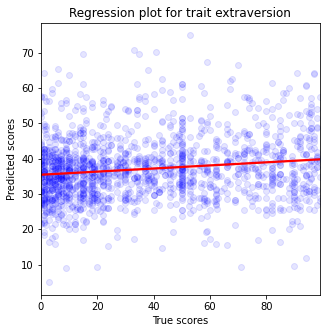


Trait to predict:  agreeableness ( mlp_reg )

Average score (R squared):  0.010559225692649976 
Average MSE:  945.8590152379202
Infinite values in y true:  0
Infinite values in y pred 0


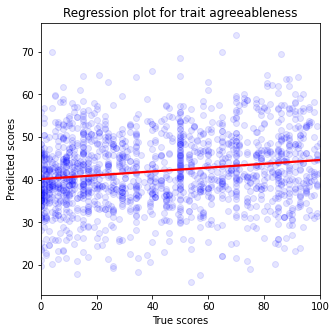


Trait to predict:  neuroticism ( mlp_reg )

Average score (R squared):  0.004704820290372358 
Average MSE:  1041.0745162758128
Infinite values in y true:  0
Infinite values in y pred 0


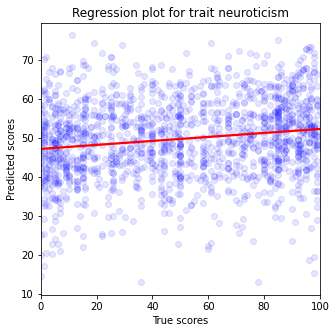

Total r squared:  -0.00686 Total MSE:  929.18228
Time for entire process: 1142.77s


In [19]:
regress(df, big5_traits, ['mlp_reg'], 'anova', dim=False, n_feat=10)

In [ ]:
regress(df, big5_traits, regres, 'anova', dim=False, n_feat=10, train=True)

In [ ]:
regress(df, big5_traits, regres, 'mutual', dim=True, n_feat=10)

In [ ]:
regress(df, big5_traits, regres, 'forward_sequential', dim=True, n_feat=10)

In [ ]:
regress(df, big5_traits, regres, 'backward_sequential', dim=True, n_feat=10)